In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier')

In [ ]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

import os
import argparse

from models import *
from utils import progress_bar

In [ ]:
print(torch.__version__)

1.7.0+cu101


In [ ]:
!nvidia-smi

Fri Nov  6 18:27:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
Epochs = 50
learning_rate = 0.001
batch_size = 32

#定义两个数组
Loss_list = []
Train_Accuracy_list = []
Test_Accuracy_list = []
Loss_list.append(3)
Test_Accuracy_list.append(0)
Train_Accuracy_list.append(0)

In [ ]:
# Data
# 获取数据集，并先进行预处理
print('==> Preparing data..')
# 图像预处理和增强
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

'''下载训练集 CIFAR-10 10分类训练集'''
trainset = datasets.CIFAR10(root='/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)  # batch_size=128
testset = datasets.CIFAR10(root='/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)   # batch_size=100

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Model
# 继续训练模型或新建一个模型
print('==> Building model..')
net = VGG('VGG16')
net = net.to(device)
# 如果GPU可用，使用GPU
if device == 'cuda':
    # move param and buffer to GPU
    # net.cuda()
    # parallel use GPU
    #net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()-1))
    net = torch.nn.DataParallel(net)
    # speed up slightly
    cudnn.benchmark = True

#　是否加载预训练好的模型
if False:   
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint')  #('./checkpoint'), 'Error: no checkpoint directory found!'
    
    # .pth格式模型加载
    #checkpoint = torch.load('/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint/ckpt.pth')
    #net.load_state_dict(checkpoint['net'])
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']
    
    # .pkl格式模型加载
    net.load_state_dict(torch.load('/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint/ckpt.pkl'))
　　
    # 如果提示module.出错放开下面的代码
    """
    new_state_dict = OrderedDict()
    for k, v in net_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    # load params
    net.load_state_dict(new_state_dict)
    """
    
for i in net._modules.items():
    print(i)

==> Building model..
==> Resuming from checkpoint..
('module', VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
# 定义度量和优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)    # lr=args.lr

In [ ]:
# Training
# 训练阶段
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    # batch 数据
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # 将数据移到GPU上
        #if use_cuda:
            #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.to(device), targets.to(device)    
        # 先将optimizer梯度先置为0
        optimizer.zero_grad()
        # Variable表示该变量属于计算图的一部分，此处是图计算的开始处。图的leaf variable
        # inputs, targets = Variable(inputs), Variable(targets)
        # 模型输出
        outputs = net(inputs)
        # 计算loss，图的终点处
        loss = criterion(outputs, targets)
        # 反向传播，计算梯度
        loss.backward()
        # 更新参数
        optimizer.step()
        # 注意如果你想统计loss，切勿直接使用loss相加，而是使用loss.data[0]。因为loss是计算图的一部分，如果你直接加loss，代表total loss同样属于模型一部分，那么图就越来越大
        #train_loss += loss.data[0]
        train_loss += loss.item()
        # 数据统计
        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets.data).cpu().sum()
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
        if total == len(trainset):
            print('Finish {} epoch, train_Loss: {:.6f}, train_Acc: {:.6f}, train_correct: {:.6f}, total: {:.6f}'.format(epoch + 1, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
            Loss_list.append(train_loss/(batch_idx+1))
            Train_Accuracy_list.append(100.*correct/total)

In [ ]:
# 测试阶段
def test(epoch):
    global best_acc
    # 先切到测试模型
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #if use_cuda:
                #inputs, targets = inputs.cuda(), targets.cuda()   
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # loss is variable , if add it(+=loss) directly, there will be a bigger ang bigger graph.
            # test_loss += loss.data[0]
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            #_, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            #correct += predicted.eq(targets.data).cpu().sum()
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            if total == len(testset):
                print('Finish {} epoch, test_Loss: {:.6f}, test_Acc: {:.6f}, test_correct: {:.6f}, total: {:.6f}'.format(epoch + 1, test_loss/total, 100.*correct/total, correct, total))
                Test_Accuracy_list.append(100.*correct/total)

    # Save checkpoint.
    # 保存模型
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {'net': net.state_dict(), 'acc': acc, 'epoch': epoch,}
        #if not os.path.isdir('checkpoint'):
        #    os.mkdir('/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint2')
        torch.save(state, '/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint/ckpt.pth')
        torch.save(net.state_dict(), '/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/checkpoint/ckpt.pkl')
        best_acc = acc

In [ ]:
# 运行模型
for epoch in range(start_epoch, start_epoch + Epochs):
    train(epoch)
    test(epoch)
    # 清除部分无用变量 
    torch.cuda.empty_cache()
print(best_acc)


Epoch: 0
 [================================================================>]  Step: 218ms | Tot: 56s8ms | Loss: 1.510 | Acc: 43.892% (21946/50000) 1563/1563 
Finish 1 epoch, train_Loss: 1.509883, train_Acc: 43.892000, train_correct: 21946.000000, total: 50000.000000
 [================================================================>]  Step: 13ms | Tot: 6s289ms | Loss: 1.033 | Acc: 62.970% (6297/10000) 313/313 
Finish 1 epoch, test_Loss: 0.032340, test_Acc: 62.970000, test_correct: 6297.000000, total: 10000.000000
Saving..

Epoch: 1
 [================================================================>]  Step: 28ms | Tot: 56s520ms | Loss: 1.005 | Acc: 64.462% (32231/50000) 1563/1563 
Finish 2 epoch, train_Loss: 1.004811, train_Acc: 64.462000, train_correct: 32231.000000, total: 50000.000000
 [================================================

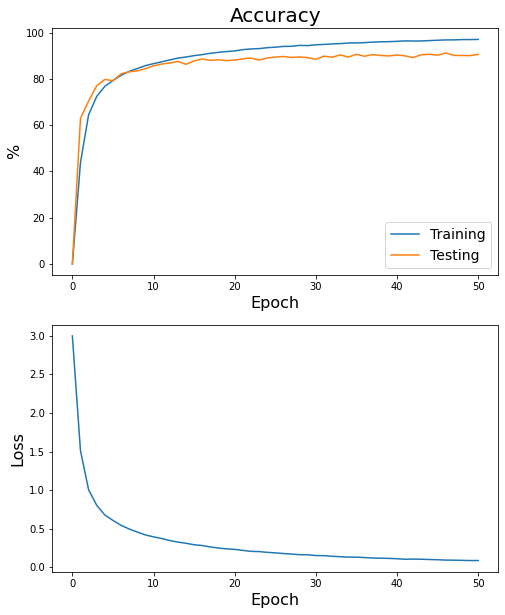

In [ ]:
x1 = range(0, 51)
x2 = range(0, 51)
y1 = Train_Accuracy_list
y2 = Test_Accuracy_list

fig = plt.figure(figsize=(8,10))
#ax = plt.axes()
plt.subplot(2, 1, 1)
#plt.plot(x1, y1, '', y2, '')
plt.plot(x1, y1, '', label='Training')
plt.plot(x1, y2, '', label='Testing')
plt.title('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('%',fontsize=16)
plt.legend(fontsize=14) # 将样例显示出来

y3 = Loss_list
plt.subplot(2, 1, 2)
plt.plot(x2, y3, '')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.savefig("/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/accuracy_loss.png")
plt.show()

In [ ]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')

    ax2.bar(np.arange(10), ps)
    ax2.set_aspect(10)
    ax2.set_xticks(np.arange(10))
    ax2.set_xticklabels(list(classes_dict.values()), size='small',rotation=45,fontsize=13);
    ax2.set_title(title,fontsize=20)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig("/content/drive/My Drive/Projects/Computer_Vision_and_Deep_Learning/VGG16_Classifier/predict.png")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


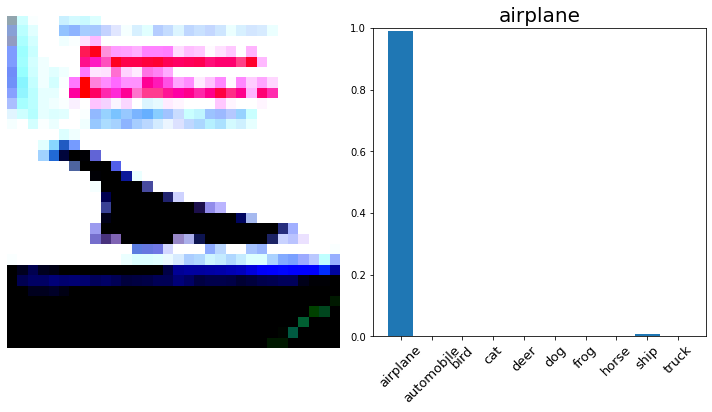

In [ ]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[3]
    label_true = labels[3]
    ps = net(inputs)
    view_classify(img.cpu(), torch.softmax(ps[3].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict Label is: tensor([-2.8016, -3.5540,  0.1062,  3.5636,  1.6647,  8.7944, -0.8450,  0.3080,
        -2.8481, -4.0245], device='cuda:0', grad_fn=<SelectBackward>)
Real Label is : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])


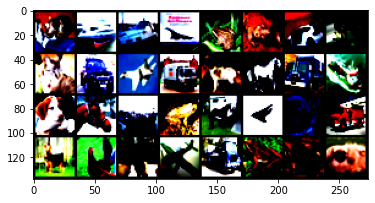

In [ ]:
X_test, y_test = next(iter(testloader))
inputs = Variable(X_test)
pred = net(inputs)
# _, pred = torch.max(pred, 1)
print("Predict Label is:", pred[12])
print("Real Label is :", y_test)
img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()